<a href="https://colab.research.google.com/github/aikokass82-design/home-tasks-/blob/main/Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Дипломный проект**

***часть 1***

In [125]:
import pandas as pd
import sqlalchemy
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')
engine = sqlalchemy.create_engine("sqlite+pysqlite:////content/drive/MyDrive/Colab Notebooks/sales_land_auctions.db", echo=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
query = sqlalchemy.text("""
SELECT *
FROM auctions
""")
table_part = pd.read_sql(query, con=engine)
table_part.head(5)

,auction_id,classificator,additional_classificator,lot_description,land_area,cadastral_number,property_type,start_price,sale_price,customer_edrpou,auction_date,expert_eval_price,lot_address,Latitude,Longitude,oblast,mortgage
0,LSE001-UA-20231006-40023,06111000-3,007.01,Земельна ділянка несільськогосподарського приз...,0.0543,4623610100:02:002:0598,Комунальна,417024.0,459832.0,4372187,2023-11-14,417024.0,"81105 Україна, Львівська область, ПУСТОМИТИ, ,...",49.747980,23.924056,Львівська,0
1,LSE001-UA-20231005-11653,06128000-5,011.00,"Продаж земельної ділянки площею 4,2089 га, кад...",4.2089,7324510100:04:001:0188,Комунальна,3513169.0,4601000.0,4062179,2023-11-13,3513169.0,"59000 Україна, Чернівецька область, Сторожинец...",48.163418,25.718429,Чернівецька,0
2,LSE001-UA-20231010-55788,06112000-0,03.08,Продаж права власності земельної ділянки площе...,0.0150,7110136400:01:012:0028,Комунальна,472800.0,520000.0,38715770,2023-11-10,472800.0,"18018 Україна, Черкаська область, Черкаси, вул...",49.439875,32.082112,Черкаська,0
3,LSE001-UA-20231006-45605,06128000-5,11.02,Продаж земельної ділянки несільськогосподарськ...,0.1224,4610300000:14:040:0108,Комунальна,190592.0,192592.0,26181298,2023-11-08,190592.0,"82300 Україна, Львівська область, м.Борислав, ...",49.300083,23.422556,Львівська,0
4,LSE001-UA-20231006-90766,06128000-5,11.02,Продаж земельної ділянки несільськогосподарськ...,0.0429,4610300000:14:040:0107,Комунальна,67182.0,70000.0,26181298,2023-11-08,67182.0,"82300 Україна, Львівська область, м.Борислав, ...",49.297918,23.425799,Львівська,0


In [127]:
query = sqlalchemy.text("""
SELECT *
FROM classificator
""")
table_part = pd.read_sql(query, con=engine)
table_part.head(5)

,classificator_code,classificator_description,classificator_class
0,06111000-3,"Землі житлової забудови (землі, які використо...",housing
1,06128000-5,"Землі промисловості, транспорту, зв'язку, ене...",industry_infrastructure
2,06112000-0,"Землі громадської забудови (землі, які викори...",public_development
3,06121000-6,Землі сільськогосподарського призначення,agriculture
4,06124000-7,Землі рекреаційного призначення,recreational


In [128]:
query = sqlalchemy.text("""
SELECT *
FROM additional_classificator
""")
table_part = pd.read_sql(query, con=engine)
table_part.head(5)

,code,code_description
0,007.01,Малоповерхова забудова
1,011.00,Землі під промисловою забудовою
2,03.08,Для будівництва та обслуговування об'єктів тур...
3,11.02,"Для розміщення та експлуатації основних, підсо..."
4,12.04,Для розміщення та експлуатації будівель і спор...


In [129]:
query = sqlalchemy.text("""
SELECT *
FROM customers
""")
table_part = pd.read_sql(query, con=engine)
table_part.head(5)

,customer_edrpou,customer_name,customer_address
0,4372187,Пустомитівська міська рада Львівського району ...,"81100 Україна, м.Пустомити, Львівська область,..."
1,4062179,СТОРОЖИНЕЦЬКА МІСЬКА РАДА,"59000 Україна, Сторожинець, Чернівецька област..."
2,38715770,Департамент архітектури та містобудування Черк...,"18000 Україна, Черкаси, Черкаська область, Бай..."
3,26181298,Бориславська міська рада,"82300 Україна, м. Борислав, Львівська область,..."
4,4051336,ЛЮБОМЛЬСЬКА МІСЬКА РАДА,"44300 Україна, м.Любомль, Волинська область, в..."


***часть 2***

In [130]:
auctions = pd.read_sql("SELECT * FROM auctions", engine)
customers = pd.read_sql("SELECT * FROM customers", engine)
classificator = pd.read_sql("SELECT * FROM classificator", engine)
additional_classificator = pd.read_sql("SELECT * FROM additional_classificator", engine)
df_main = auctions.merge(customers, how='left', on='customer_edrpou')
df_main = df_main.merge(classificator, how='left', left_on='classificator', right_on='classificator_code')
df_main = df_main.merge(additional_classificator, how='left', left_on='additional_classificator', right_on='code')

df_main['auction_date'] = pd.to_datetime(df_main['auction_date'], errors='coerce')

In [131]:
#1
query = sqlalchemy.text("""
SELECT oblast,
SUM(land_area) as total_area
FROM auctions
GROUP BY oblast
ORDER BY total_area DESC""")
sum_area = pd.read_sql(query, engine)
sum_area

,oblast,total_area
0,Київська,3435.8437
1,Одеська,379.4773
2,Дніпропетровська,300.6960
3,Полтавська,294.5786
4,Чернігівська,258.7536
5,Кіровоградська,254.1767
6,Черкаська,223.6999
7,Хмельницька,196.4711
8,Львівська,118.9082
9,Вінницька,80.4282


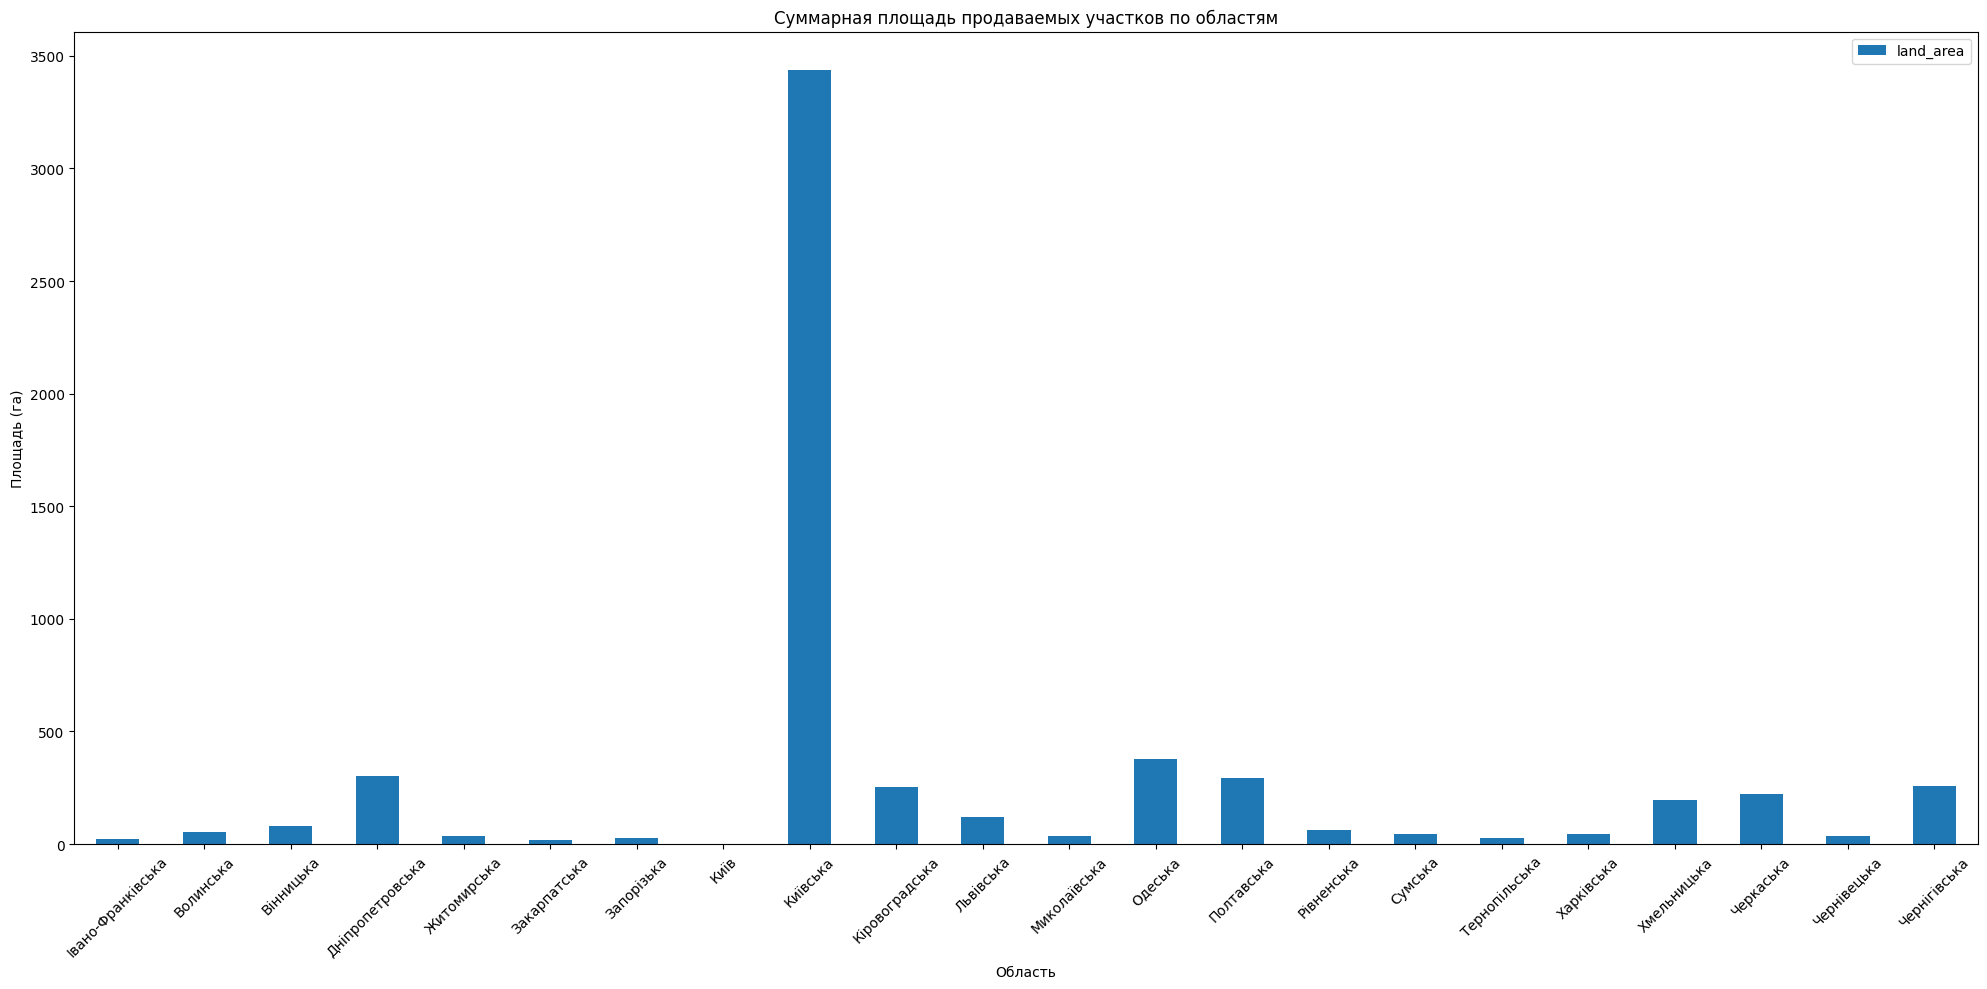

In [132]:
sum_area = df_main.groupby("oblast")['land_area'].sum().reset_index()

sum_area.plot(kind='bar', x='oblast', y='land_area', figsize=(20,10))
plt.title("Суммарная площадь продаваемых участков по областям")
plt.xlabel("Область")
plt.ylabel("Площадь (га)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [133]:
#2
query= sqlalchemy.text("""
SELECT
oblast,
COUNT(*) AS lot_count
FROM auctions
GROUP BY oblast
ORDER BY lot_count DESC
""")

lots_count= pd.read_sql(query, con=engine)
print(lots_count)

               oblast  lot_count
0           Львівська        202
1            Київська        182
2           Черкаська        130
3         Хмельницька        123
4        Чернігівська        107
5             Одеська        103
6          Полтавська         94
7           Волинська         94
8    Дніпропетровська         83
9          Рівненська         78
10     Кіровоградська         74
11        Чернівецька         72
12       Закарпатська         64
13          Вінницька         44
14      Тернопільська         37
15        Житомирська         30
16  Івано-Франківська         28
17            Сумська         18
18         Харківська         13
19         Запорізька          8
20       Миколаївська          6
21               Київ          6


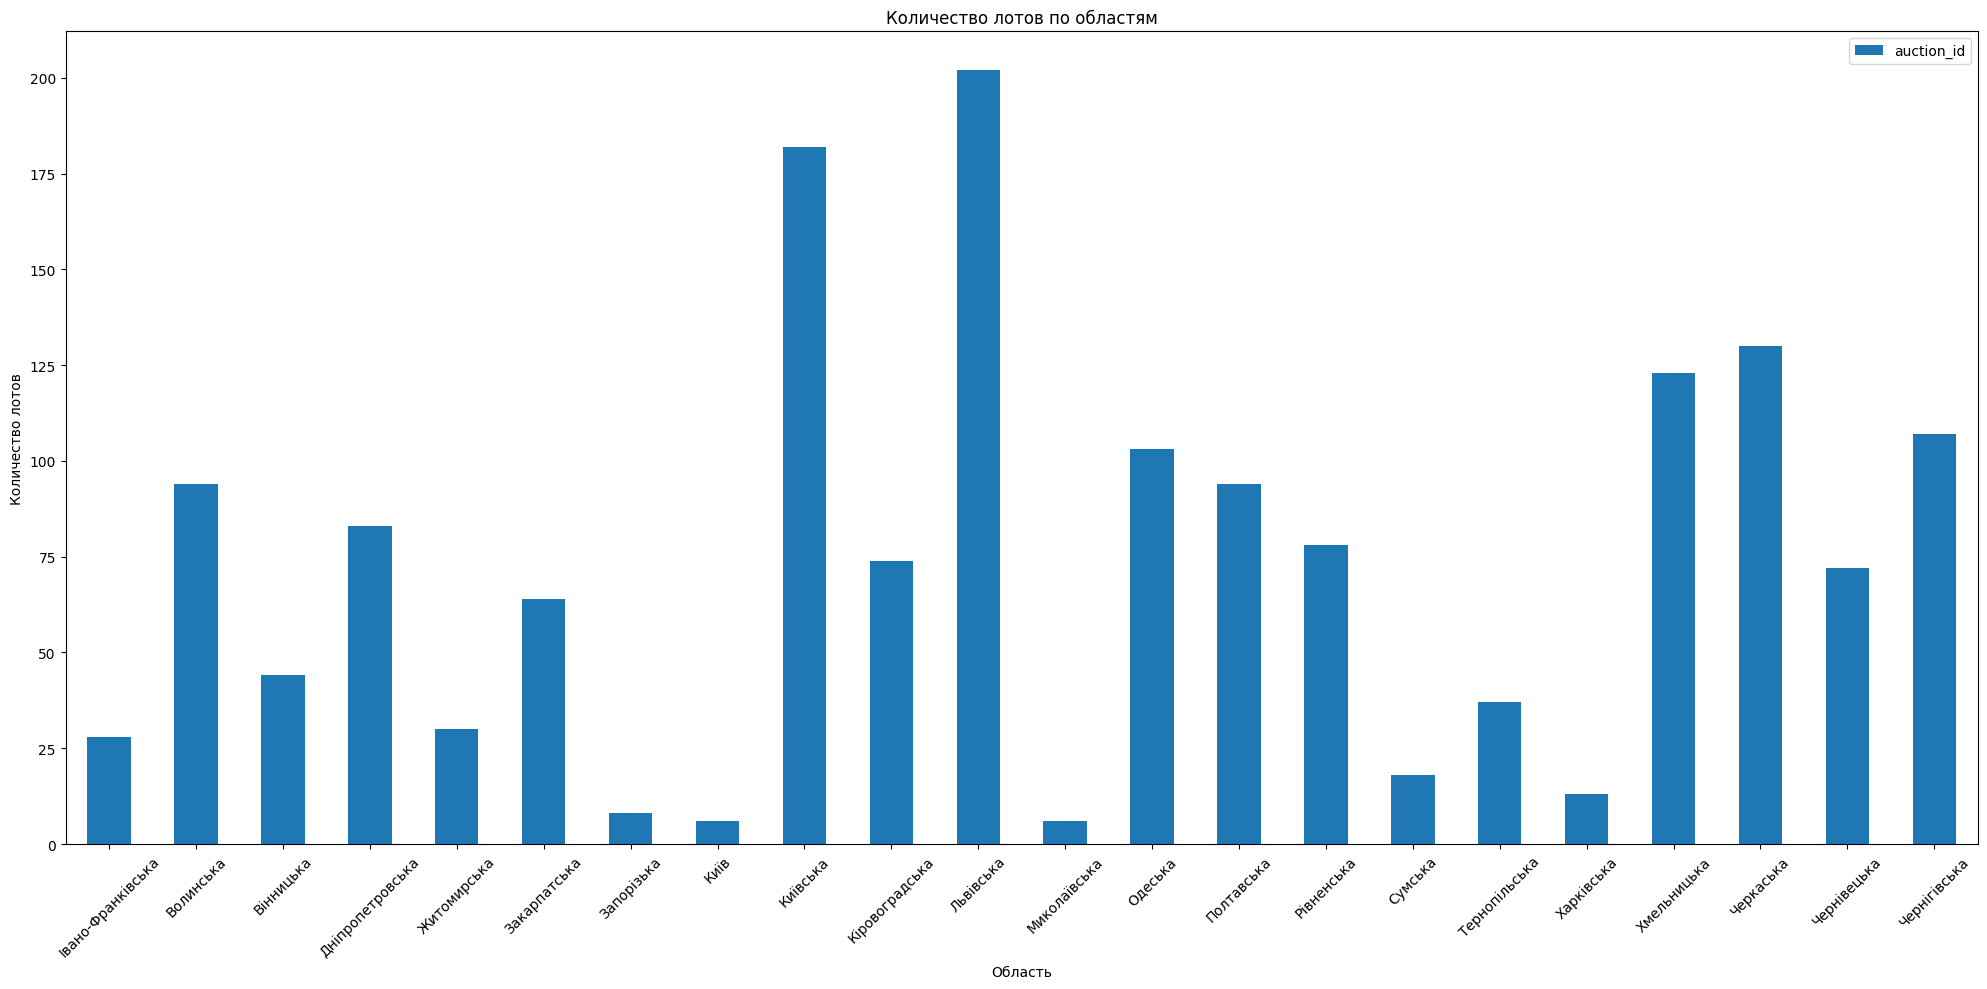

In [134]:
lots_count = df_main.groupby("oblast")['auction_id'].count().reset_index()

lots_count.plot(kind='bar', x='oblast', y='auction_id', figsize=(20,10))
plt.title("Количество лотов по областям")
plt.xlabel("Область")
plt.ylabel("Количество лотов")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [135]:
#3
query = sqlalchemy.text("""
    SELECT
        strftime('%Y', auction_date) AS year,
        oblast,
        COUNT(*) AS lot_count
    FROM auctions
    GROUP BY year, oblast
    ORDER BY year DESC, lot_count DESC
""")

lots_year = pd.read_sql(query, con=engine)
print(lots_year)

    year             oblast  lot_count
0   2023          Львівська        118
1   2023           Київська        110
2   2023          Черкаська         89
3   2023        Хмельницька         81
4   2023            Одеська         75
5   2023       Чернігівська         60
6   2023         Рівненська         60
7   2023         Полтавська         54
8   2023          Волинська         51
9   2023        Чернівецька         43
10  2023     Кіровоградська         43
11  2023   Дніпропетровська         43
12  2023          Вінницька         36
13  2023       Закарпатська         24
14  2023      Тернопільська         23
15  2023            Сумська         17
16  2023        Житомирська         15
17  2023  Івано-Франківська         15
18  2023         Харківська          7
19  2023               Київ          5
20  2023       Миколаївська          3
21  2023         Запорізька          1
22  2022          Львівська         70
23  2022           Київська         52
24  2022       Чернігівсь

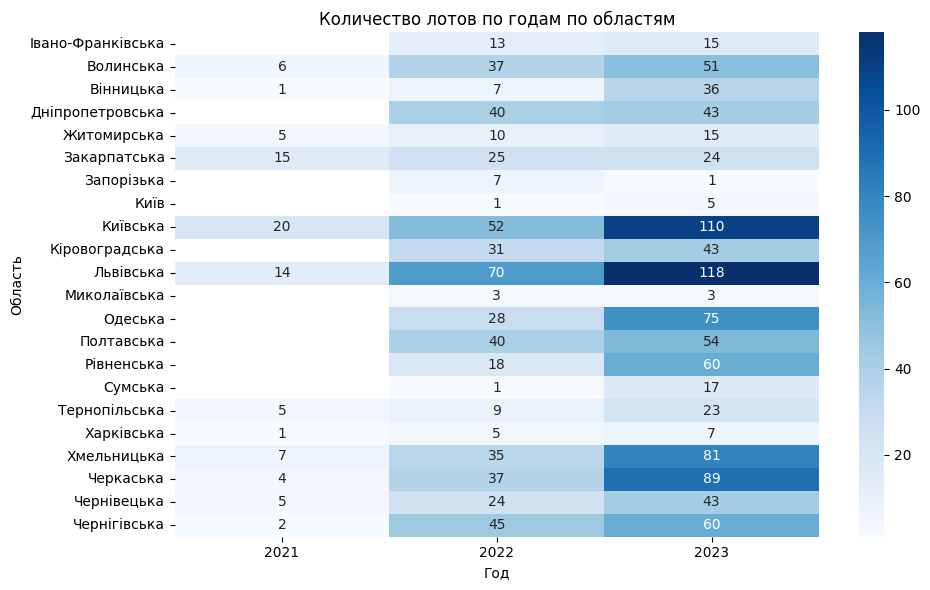

In [136]:
import seaborn as sns
lots_year['lot_count'] = pd.to_numeric(lots_year['lot_count'], errors='coerce')
lots_year['year'] = lots_year['year'].astype(str)
pivot = lots_year.pivot(index='oblast', columns='year', values='lot_count')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt="g", cmap="Blues")
plt.title("Количество лотов по годам по областям")
plt.xlabel("Год")
plt.ylabel("Область")
plt.tight_layout()
plt.show()

In [137]:
#4
query = sqlalchemy.text(""" SELECT
 a.oblast,
c.classificator_code,
c.classificator_description,
COUNT(*) AS lot_count FROM auctions a
JOIN classificator c
ON a.classificator = c.classificator_code
GROUP BY a.oblast, c.classificator_code, c.classificator_description """)
df = pd.read_sql(query, con=engine)
most_common_per_oblast = df.loc[df.groupby('oblast')['lot_count'].idxmax()]
print(most_common_per_oblast)

               oblast classificator_code  \
5   Івано-Франківська         06128000-5   
10          Волинська         06128000-5   
13          Вінницька         06121000-6   
18   Дніпропетровська         06121000-6   
22        Житомирська         06121000-6   
25       Закарпатська         06112000-0   
29         Запорізька         06121000-6   
30               Київ         06111000-3   
36           Київська         06121000-6   
41     Кіровоградська         06121000-6   
44          Львівська         06112000-0   
47       Миколаївська         06121000-6   
49            Одеська         06121000-6   
52         Полтавська         06121000-6   
56         Рівненська         06121000-6   
59            Сумська         06121000-6   
61      Тернопільська         06112000-0   
64         Харківська         06121000-6   
67        Хмельницька         06121000-6   
72          Черкаська         06121000-6   
76        Чернівецька         06112000-0   
82       Чернігівська         06

In [138]:
#5
industrial = df[df['classificator_code'] == '011.00']

if not industrial.empty:
    count_by_oblast = industrial['oblast'].value_counts()
    top_oblast = count_by_oblast.idxmax()
    max_count = count_by_oblast.max()
    print(f"Больше всего промышленных участков выставлено в области: {top_oblast} ({max_count} участков)")
else:
    print("В данных нет участков с кодом '011.00' (земли под промышленную застройку)")

industrial_lands = df[df['classificator_description'].str.contains('промислов', case=False, na=False)]
count_by_oblast = industrial_lands['oblast'].value_counts()
top_oblast = count_by_oblast.idxmax()
max_count = count_by_oblast.max()
print(f"Больше всего земель под промышленную застройку выставлено в области: {top_oblast} ({max_count} участков)")

В данных нет участков с кодом '011.00' (земли под промышленную застройку)
Больше всего земель под промышленную застройку выставлено в области: Івано-Франківська (1 участков)


In [139]:
#6
lot_counts = df.groupby(['oblast', 'classificator_description']).size().reset_index(name='lot_count')
lot_counts = lot_counts.sort_values(by='lot_count', ascending=False)
print(lot_counts)

               oblast                          classificator_description  \
0   Івано-Франківська   Землі громадської забудови (землі, які викори...   
1   Івано-Франківська   Землі житлової забудови (землі, які використо...   
2   Івано-Франківська                      Землі оздоровчого призначення   
3   Івано-Франківська   Землі промисловості, транспорту, зв'язку, ене...   
4   Івано-Франківська                    Землі рекреаційного призначення   
..                ...                                                ...   
79        Чернівецька           Землі сільськогосподарського призначення   
80       Чернігівська   Землі громадської забудови (землі, які викори...   
81       Чернігівська   Землі житлової забудови (землі, які використо...   
82       Чернігівська   Землі промисловості, транспорту, зв'язку, ене...   
83       Чернігівська           Землі сільськогосподарського призначення   

    lot_count  
0           1  
1           1  
2           1  
3           1  
4      

***часть 3***

In [140]:
auctions = pd.read_sql("SELECT * FROM auctions", engine)
customers = pd.read_sql("SELECT * FROM customers", engine)
classificator = pd.read_sql("SELECT * FROM classificator", engine)
additional_classificator = pd.read_sql("SELECT * FROM additional_classificator", engine)

df = auctions.merge(customers, how='left', on='customer_edrpou')
df = df.merge(classificator, how='left', left_on='classificator', right_on='classificator_code')
df = df.merge(additional_classificator, how='left', left_on='additional_classificator', right_on='code')
print(df.columns)

Index(['auction_id', 'classificator', 'additional_classificator',
       'lot_description', 'land_area', 'cadastral_number', 'property_type',
       'start_price', 'sale_price', 'customer_edrpou', 'auction_date',
       'expert_eval_price', 'lot_address', 'Latitude', 'Longitude', 'oblast',
       'mortgage', 'customer_name', 'customer_address', 'classificator_code',
       'classificator_description', 'classificator_class', 'code',
       'code_description'],
      dtype='object')


In [141]:
#1
auctions["auction_date"] = pd.to_datetime(auctions["auction_date"]).dt.normalize()

min_date = auctions["auction_date"].min()
max_date = auctions["auction_date"].max()
print(f"Период присутствующих данных: {min_date.date()} — {max_date.date()}")

unique_dates = pd.to_datetime(auctions["auction_date"].unique())

print(f"Количество уникальных дат аукционов: {len(unique_dates)}")
rates = []

for d in unique_dates:
    date_str = d.strftime("%Y%m%d")
    url = f"https://bank.gov.ua/NBUStatService/v1/statdirectory/exchange?valcode=EUR&date={date_str}&json"
    resp = requests.get(url)
    data = resp.json()

    if not data:
        continue

    rate = float(data[0]["rate"])
    ex_date = pd.to_datetime(data[0]["exchangedate"], format="%d.%m.%Y").normalize()

    rates.append({
        "auction_date": ex_date,
        "eur_rate": rate
    })
eur_rate_df = (
    pd.DataFrame(rates)
    .drop_duplicates(subset=["auction_date"])
    .sort_values("auction_date")
    .reset_index(drop=True)
)

print("строк в eur_rate_df:", len(eur_rate_df))
display(eur_rate_df.head())

if "eur_rate" in auctions.columns:
    auctions = auctions.drop(columns=["eur_rate"])

auctions = auctions.merge(
    eur_rate_df,
    on="auction_date",
    how="left"
)
auctions["eur_rate"] = auctions["eur_rate"].astype(float)
auctions["eur_rate"] = auctions["eur_rate"].ffill().bfill()
auctions[["auction_id", "auction_date", "eur_rate"]].head(10)

Период присутствующих данных: 2021-11-08 — 2023-11-14
Количество уникальных дат аукционов: 405
строк в eur_rate_df: 405


,auction_date,eur_rate
0,2021-11-08,30.0969
1,2021-11-11,30.1186
2,2021-11-15,29.9007
3,2021-11-17,30.0266
4,2021-11-18,29.9974


,auction_id,auction_date,eur_rate
0,LSE001-UA-20231006-40023,2023-11-14,38.5945
1,LSE001-UA-20231005-11653,2023-11-13,38.5420
2,LSE001-UA-20231010-55788,2023-11-10,38.5225
3,LSE001-UA-20231006-45605,2023-11-08,38.4840
4,LSE001-UA-20231006-90766,2023-11-08,38.4840
5,LSE001-UA-20231006-47411,2023-11-08,38.4840
6,LSP001-UA-20230922-18241,2023-11-07,38.7206
7,LSP001-UA-20230922-26268,2023-11-07,38.7206
8,LSE001-UA-20231005-99295,2023-11-06,38.7278
9,LSE001-UA-20231004-50922,2023-11-06,38.7278


In [142]:
#2
auctions["start_price_eur"] = (auctions["start_price"] / auctions["eur_rate"]).round(2)
auctions["sale_price_eur"] = (auctions["sale_price"] / auctions["eur_rate"]).round(2)
auctions["expert_eval_price_eur"] = (auctions["expert_eval_price"] / auctions["eur_rate"]).round(2)

print("Первые 10 строк с пересчитанными ценами в евро:")
print(auctions[[
    "auction_id",
    "auction_date",
    "start_price", "start_price_eur",
    "sale_price", "sale_price_eur",
    "expert_eval_price", "expert_eval_price_eur"
]].head(10))


Первые 10 строк с пересчитанными ценами в евро:
                 auction_id auction_date  start_price  start_price_eur  \
0  LSE001-UA-20231006-40023   2023-11-14     417024.0         10805.27   
1  LSE001-UA-20231005-11653   2023-11-13    3513169.0         91151.70   
2  LSE001-UA-20231010-55788   2023-11-10     472800.0         12273.35   
3  LSE001-UA-20231006-45605   2023-11-08     190592.0          4952.50   
4  LSE001-UA-20231006-90766   2023-11-08      67182.0          1745.71   
5  LSE001-UA-20231006-47411   2023-11-08     283882.0          7376.62   
6  LSP001-UA-20230922-18241   2023-11-07     130000.0          3357.39   
7  LSP001-UA-20230922-26268   2023-11-07     130000.0          3357.39   
8  LSE001-UA-20231005-99295   2023-11-06      73300.0          1892.70   
9  LSE001-UA-20231004-50922   2023-11-06    1275834.0         32943.62   

   sale_price  sale_price_eur  expert_eval_price  expert_eval_price_eur  
0    459832.0        11914.44          417024.00               

In [143]:
#3
df_valid = auctions[(auctions['sale_price_eur'].notna()) & (auctions['land_area'].notna()) & (auctions['land_area'] > 0)].copy()
df_valid['price_per_ha_eur'] = df_valid['sale_price_eur'] / df_valid['land_area']

avg_price_per_ha = (
    df_valid.groupby(['oblast', 'classificator'])['price_per_ha_eur']
    .mean()
    .reset_index()
)
avg_price_per_ha['price_per_ha_eur'] = avg_price_per_ha['price_per_ha_eur'].round(2)
print("\nСредняя стоимость 1 га по областям и типу участка:")
print(avg_price_per_ha.head(20))


Средняя стоимость 1 га по областям и типу участка:
               oblast classificator  price_per_ha_eur
0   Івано-Франківська    06111000-3         133446.30
1   Івано-Франківська    06112000-0         237566.37
2   Івано-Франківська    06121000-6          20827.50
3   Івано-Франківська    06123000-0         477833.88
4   Івано-Франківська    06124000-7          12036.75
5   Івано-Франківська    06128000-5          97375.33
6           Волинська    06111000-3         115618.51
7           Волинська    06112000-0         176757.38
8           Волинська    06121000-6          14232.68
9           Волинська    06124000-7          22930.18
10          Волинська    06128000-5          62752.89
11          Вінницька    06111000-3         267405.13
12          Вінницька    06112000-0         145782.00
13          Вінницька    06121000-6           7201.85
14          Вінницька    06124000-7          23746.37
15          Вінницька    06128000-5          15779.40
16   Дніпропетровська    06111

In [144]:
#4
df_valid = df_valid[(df_valid['expert_eval_price_eur'].notna()) & (df_valid['sale_price_eur'].notna())]
df_valid['abs_error_eur'] = (df_valid['expert_eval_price_eur'] - df_valid['sale_price_eur']).abs()

avg_error_by_purpose = (
    df_valid.groupby('additional_classificator')['abs_error_eur']
    .mean()
    .reset_index()
)
avg_error_by_purpose['abs_error_eur'] = avg_error_by_purpose['abs_error_eur'].round(2)
avg_error_by_purpose = avg_error_by_purpose.sort_values('abs_error_eur', ascending=False)
print("\nСредняя погрешность оценки эксперта по типу участка (евро):")
print(avg_error_by_purpose)


Средняя погрешность оценки эксперта по типу участка (евро):
   additional_classificator  abs_error_eur
42                    06.01      508680.26
32                    02.10      242936.17
44                    07.02      122000.44
33                       03       70818.25
11                   007.02       62597.60
38                    03.08       50127.62
39                    03.10       39342.14
29                    02.03       39122.55
13                   008.03       38924.94
31                    02.09       37548.55
22                   011.00       30371.56
51                    12.02       28570.92
34                    03.02       20775.38
41                    03.15       20282.76
49                    11.03       19398.33
48                    11.02       18271.59
53                    12.08       15319.73
8                    004.00       13843.84
27                       02       13553.37
12                   008.00        9972.19
37                    03.07        9

In [145]:
#5
lots_per_seller = (
    df_valid.groupby(['oblast', 'customer_edrpou'])
    .agg(lot_count=('auction_id', 'count'),
         total_sale_eur=('sale_price_eur', 'sum'))
    .reset_index()
)
max_lots_per_region = lots_per_seller.groupby('oblast')['lot_count'].transform('max')
top_sellers = lots_per_seller[lots_per_seller['lot_count'] == max_lots_per_region]
top_sellers = top_sellers.sort_values('oblast')
print("\nПродавцы с максимальным количеством лотов и их суммарная стоимость по областям:")
print(top_sellers)


Продавцы с максимальным количеством лотов и их суммарная стоимость по областям:
                oblast customer_edrpou  lot_count  total_sale_eur
9    Івано-Франківська        33644700          7        98864.18
28           Волинська        21735504         23      1359386.07
50           Вінницька      3017114656         10        46988.30
70    Дніпропетровська      3228512088         25       136079.30
72         Житомирська         4053370          5        61411.35
96        Закарпатська         4350168          8       153973.79
109         Запорізька      3104805273          7        28528.57
111               Київ        26199097          2       973412.68
132           Київська      2605408729         34        23512.74
191     Кіровоградська      3115318390         13        37033.11
221          Львівська        26269018         20      6046759.93
249       Миколаївська      3338711211          1        16748.78
248       Миколаївська      3228512088          1         472

In [146]:
#6
avg_price_per_ha_by_purpose = (
    df_valid.groupby('additional_classificator')['price_per_ha_eur']
    .mean()
    .reset_index()
)
avg_price_per_ha_by_purpose['price_per_ha_eur'] = avg_price_per_ha_by_purpose['price_per_ha_eur'].round(2)

max_price_row = avg_price_per_ha_by_purpose.loc[avg_price_per_ha_by_purpose['price_per_ha_eur'].idxmax()]
print("\nЦелевое предназначение с самой высокой стоимостью 1 га (евро):")
print(max_price_row)


Целевое предназначение с самой высокой стоимостью 1 га (евро):
additional_classificator        02.10
price_per_ha_eur            813954.56
Name: 32, dtype: object


***Часть 4***


Киевская область является крупнейшим экономическим узлом страны, с концентрацией логистики, производств и транспортной инфраструктуры. Промышленные земли здесь стратегически важны: они привлекают инвестиции и часто демонстрируют высокую рыночную активность, что делает их интересными для анализа динамики рынка.

In [147]:
#1
kyiv_df = auctions[(auctions['oblast'] == 'Київська') &
                   (auctions['classificator'] == '06112000-0')].copy()

print(f"Количество выбранных лотов: {len(kyiv_df)}")
print(kyiv_df)

Количество выбранных лотов: 21
                    auction_id classificator additional_classificator  \
23    LSE001-UA-20230920-42505    06112000-0                   008.03   
24    LSE001-UA-20230920-85045    06112000-0                   008.03   
25    LSE001-UA-20230920-75808    06112000-0                   008.03   
27    LSE001-UA-20230919-79795    06112000-0                   008.03   
28    LSE001-UA-20230919-87660    06112000-0                   008.03   
137   LSP001-UA-20230704-53077    06112000-0                    03.07   
355   LSE001-UA-20230609-89341    06112000-0                   007.00   
509   LSE001-UA-20230425-06252    06112000-0                    03.07   
585   LSE001-UA-20230327-99179    06112000-0                    03.07   
1090  LSE001-UA-20221011-75794    06112000-0                    03.07   
1382  LSE001-UA-20220214-17805    06112000-0                    03.07   
1385  LSE001-UA-20220218-92173    06112000-0                    03.10   
1396  LSE001-UA-2022

In [148]:
#2
lot_counts = kyiv_df['additional_classificator'].value_counts().reset_index()
lot_counts.columns = ['purpose', 'lot_count']
print("Чаще всего выставляемые участки по целевому предназначению:")
print(lot_counts.head())


Чаще всего выставляемые участки по целевому предназначению:
  purpose  lot_count
0   03.07         11
1  008.03          5
2   03.10          4
3  007.00          1


In [149]:
#3
kyiv_df['price_per_ha_eur'] = (kyiv_df['sale_price_eur'] / kyiv_df['land_area']).round(2)
avg_price_per_ha = kyiv_df.groupby('additional_classificator')['price_per_ha_eur'].mean().reset_index()
avg_price_per_ha = avg_price_per_ha.sort_values('price_per_ha_eur', ascending=False)
print("Средняя стоимость 1 га по типу участка (евро):")
print(avg_price_per_ha.head())


Средняя стоимость 1 га по типу участка (евро):
  additional_classificator  price_per_ha_eur
3                    03.10     974780.530000
2                    03.07     776190.892727
1                   008.03     533595.840000
0                   007.00         20.540000


Наибольшую стоимость за гектар имеют земельные участки с целевым назначением 03.10 (комунальна). Это связано с тем, что такие участки обычно расположены в стратегически важных местах города, имеют удобную инфраструктуру или ограниченное количество, что повышает их рыночную ценность. В столичном регионе высокие цены также отражают дефицит земли и высокий спрос.

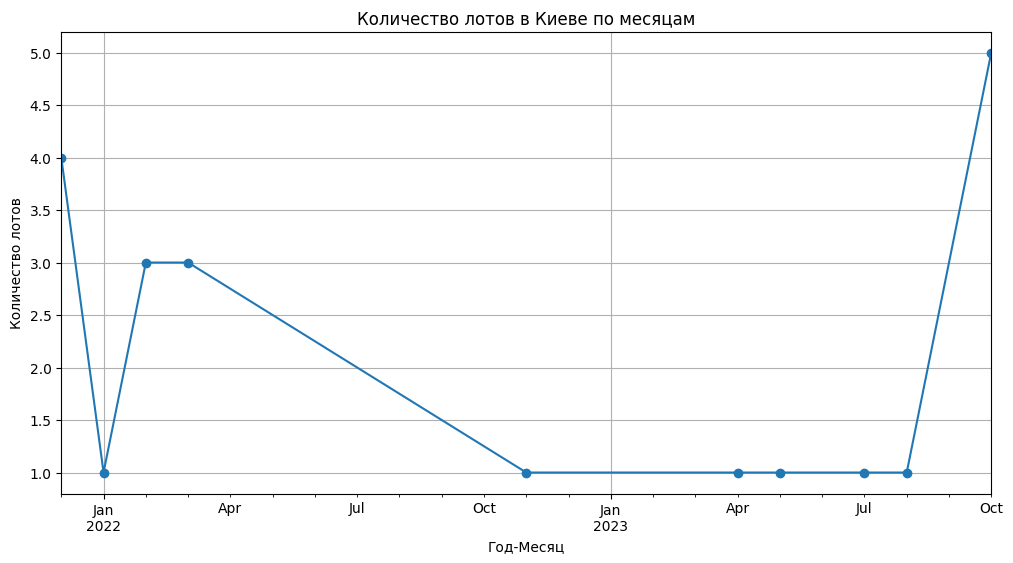

In [150]:
#4
kyiv_df['year_month'] = kyiv_df['auction_date'].dt.to_period('M')
lots_per_month = kyiv_df.groupby('year_month')['auction_id'].count()

import matplotlib.pyplot as plt

lots_per_month.plot(kind='line', marker='o', figsize=(12,6))
plt.title('Количество лотов в Киеве по месяцам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество лотов')
plt.grid(True)
plt.show()


Скорее всего из за сезонности владельцы чаще выставляют участки на продажу весной и осенью, чтобы успеть сделки в благоприятный период. Нельзя отрицать также экономическую ситуацию, например, локальные или национальные кризисы могут уменьшать или увеличивать активность на рынке.

Если тенденция повторяется ежегодно, можно ожидать постепенный рост лотов весной и осенью (также может быть и в первой половине зимы).

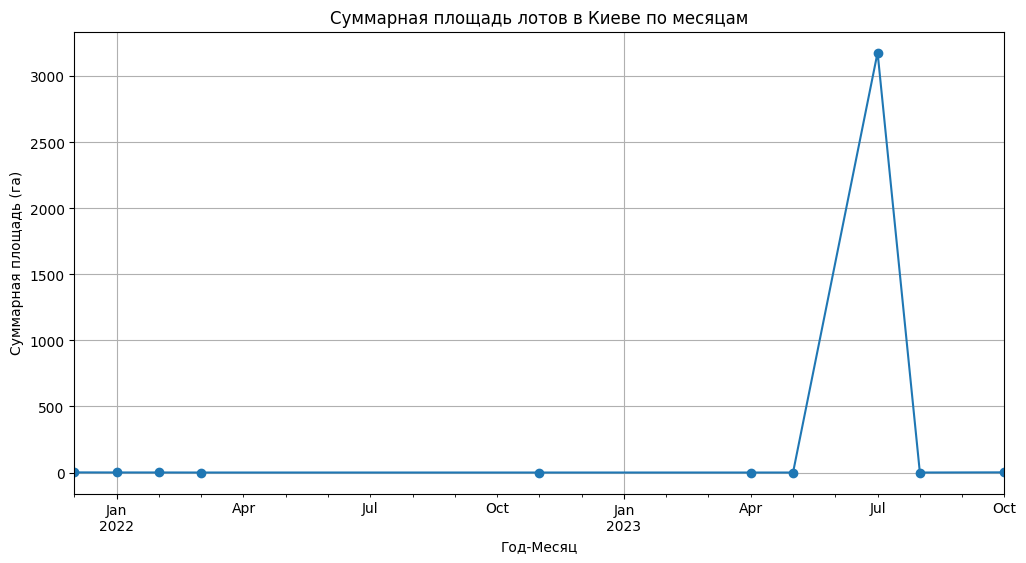

In [151]:
#5
area_per_month = kyiv_df.groupby('year_month')['land_area'].sum()

area_per_month.plot(kind='line', marker='o', figsize=(12,6))
plt.title('Суммарная площадь лотов в Киеве по месяцам')
plt.xlabel('Год-Месяц')
plt.ylabel('Суммарная площадь (га)')
plt.grid(True)
plt.show()


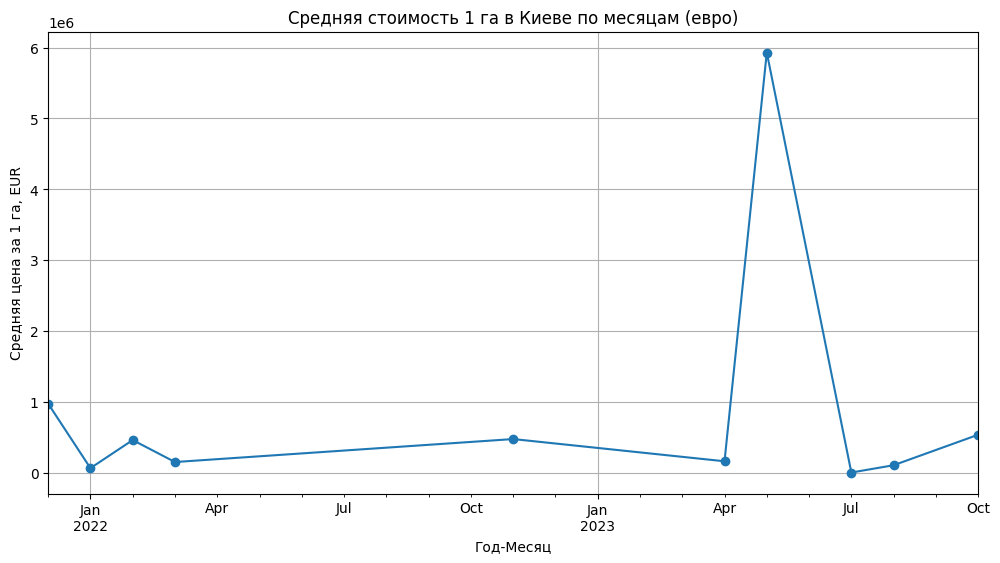

In [152]:
#6
avg_price_per_ha_month = kyiv_df.groupby('year_month')['price_per_ha_eur'].mean()

avg_price_per_ha_month.plot(kind='line', marker='o', figsize=(12,6))
plt.title('Средняя стоимость 1 га в Киеве по месяцам (евро)')
plt.xlabel('Год-Месяц')
plt.ylabel('Средняя цена за 1 га, EUR')
plt.grid(True)
plt.show()


- Наиболее популярны участки с определённым типом собственности комунальна.
- Цены на землю в Киеве высокие, особенно комунальна земля, с целевым назначением под бизнес или строительство.
- Сезонные колебанияз и экономическая ситуация влияют на количество выставленных лотов и суммарную площадь.
- Средняя стоимость за гектар постепенно растёт, что отражает дефицит земли и её высокую ценность в столичном регионе.